In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('TWDUSD=X.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,0.033509,0.033509,0.033446,0.033447,0.033447,0
1,2020-01-02,0.033399,0.033497,0.033263,0.033508,0.033508,0
2,2020-01-03,0.033342,0.033445,0.033204,0.033445,0.033445,0
3,2020-01-06,0.033269,0.033343,0.033209,0.033294,0.033294,0
4,2020-01-07,0.033356,0.033406,0.033259,0.033281,0.033281,0


In [3]:
len(df)-14

769

In [4]:
x_date=[]
for i in range(0,783,80):
    x_date.append(df['Date'][i])

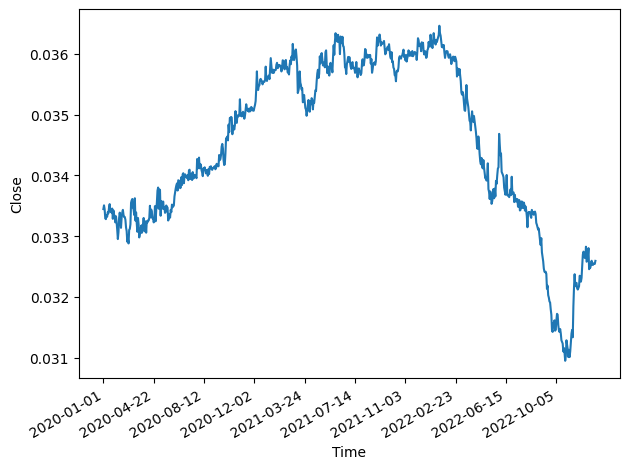

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Close'])
ax.set_xlabel('Time')
ax.set_ylabel('Close')

plt.xticks(np.arange(0,783,80),x_date)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/peixeiro.png', dpi=300)

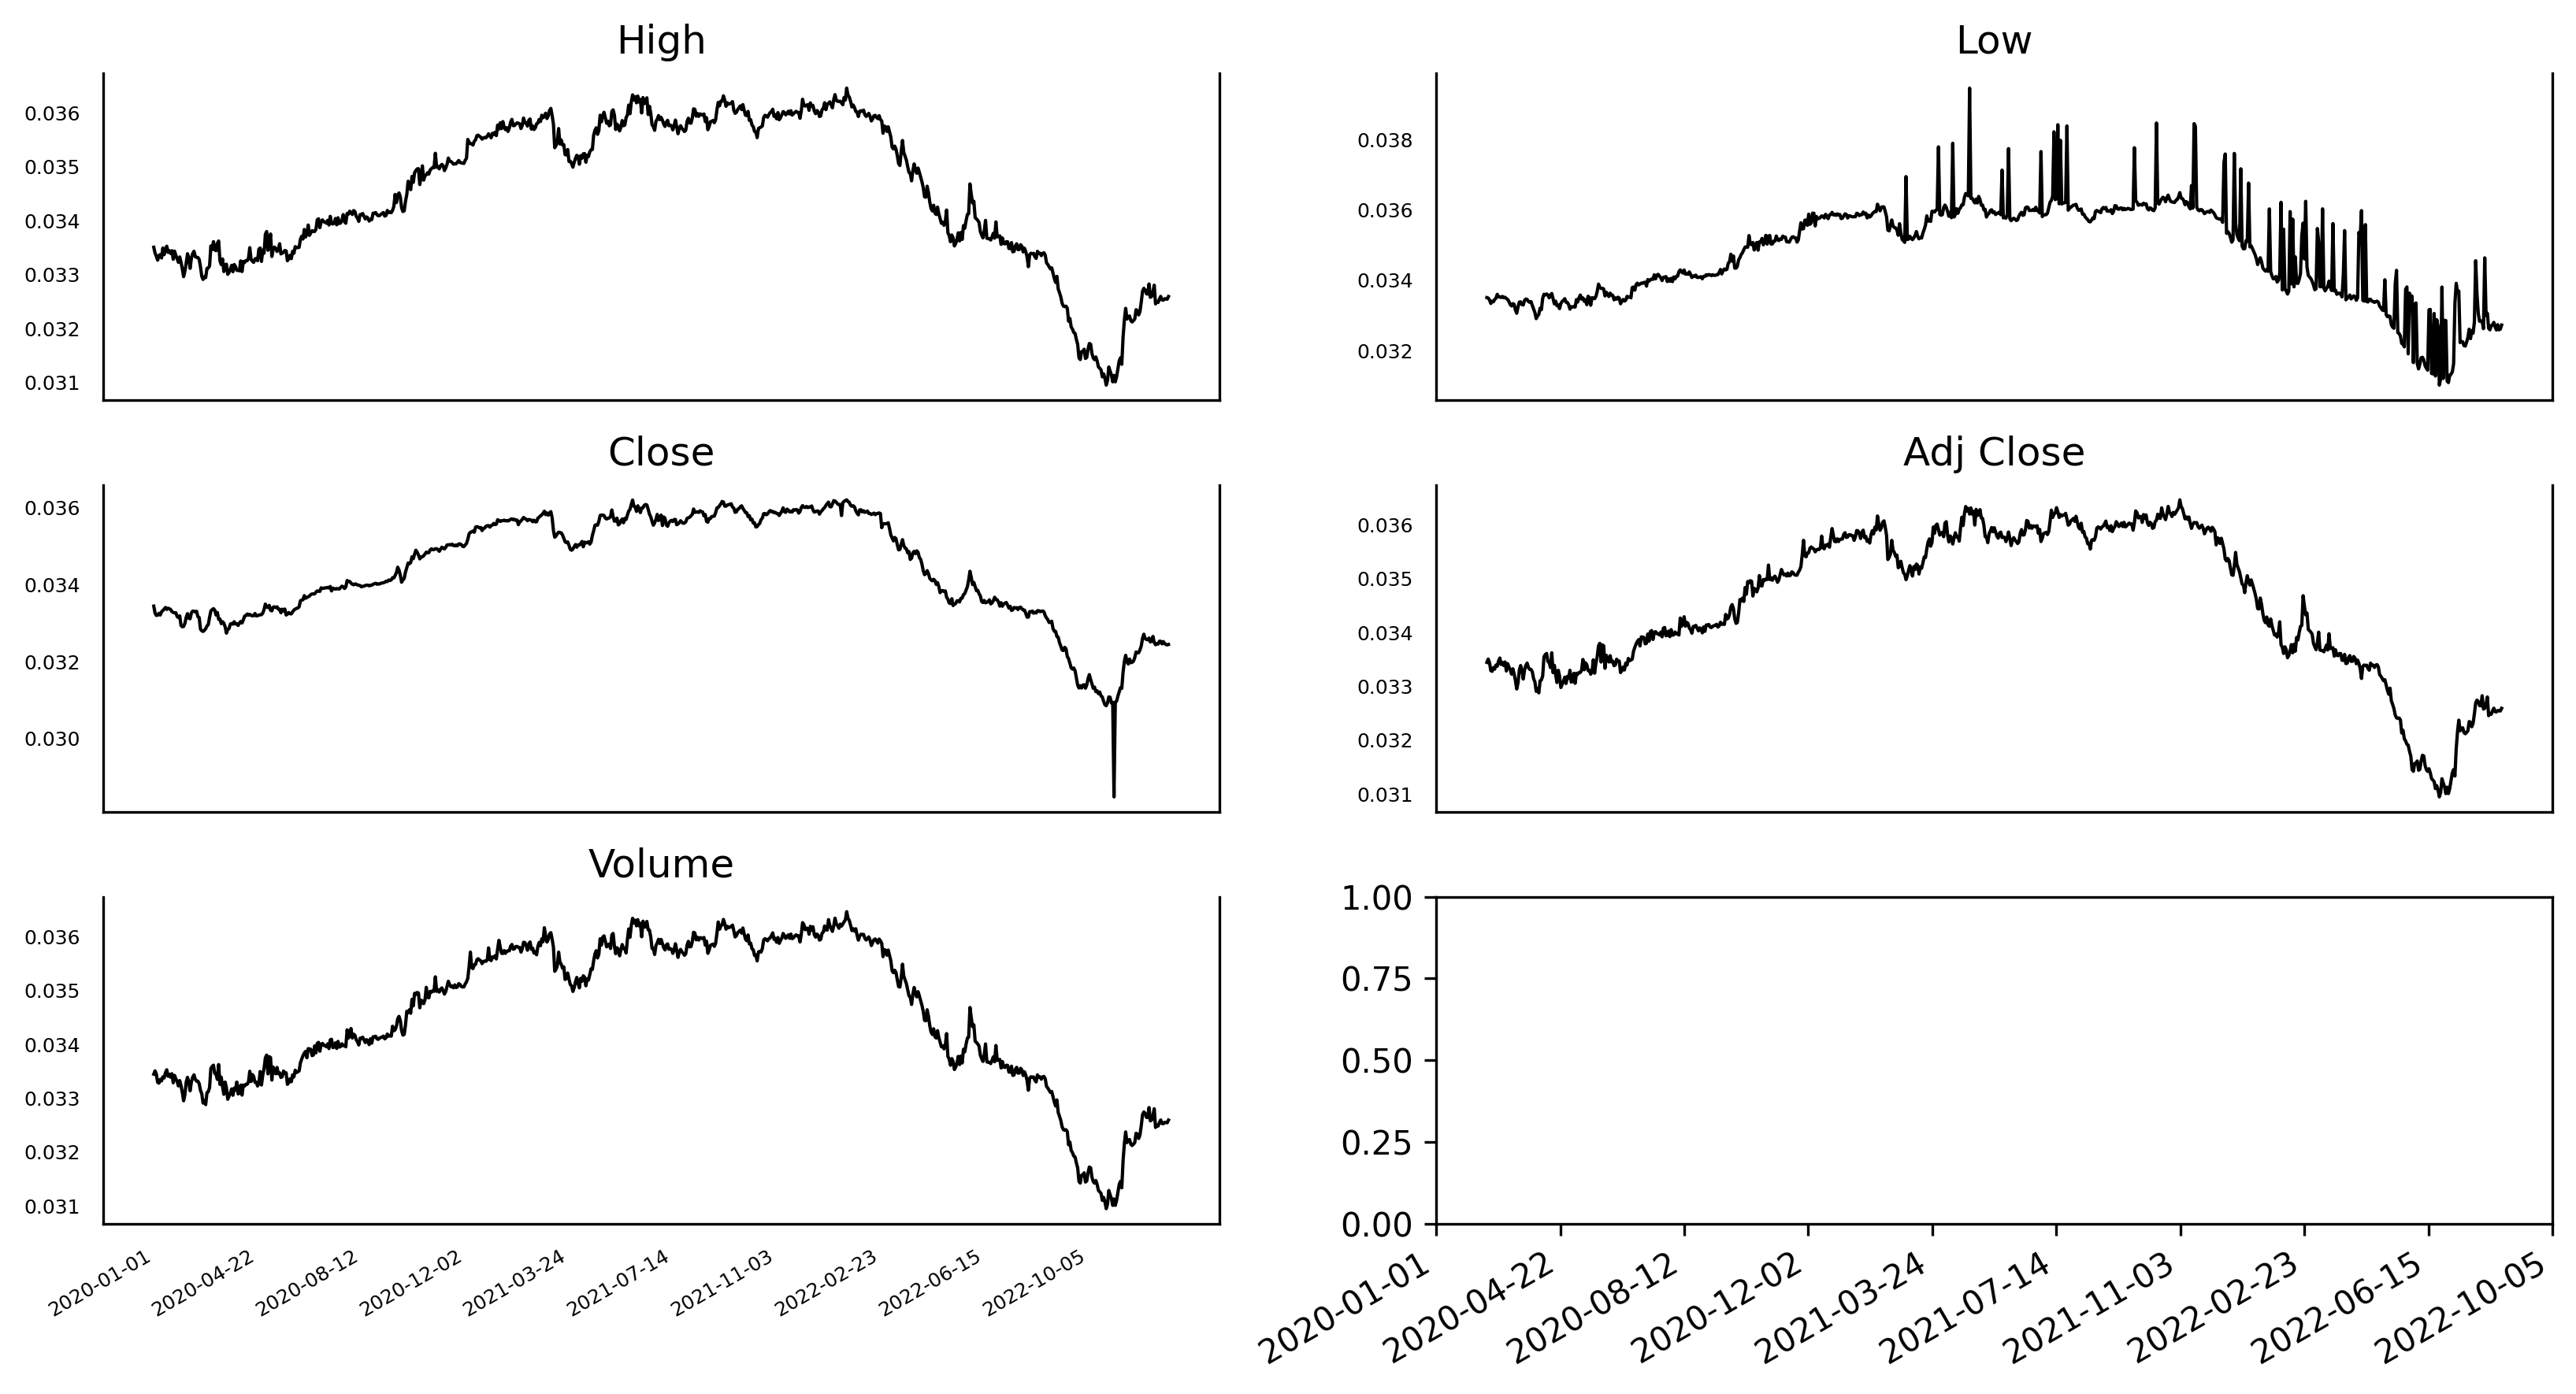

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:5]):
    data = df[df.columns[i+1]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0,783,80), xticklabels=x_date)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH09_F02_peixeiro.png', dpi=300)

In [7]:
target = df['Close']
exog = df[['Open', 'High', 'Low', 'Adj Close']]
			

In [8]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.7531622062230017
p-value: 0.8324948059826033


In [9]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -11.710637450768395
p-value: 1.4919145187137645e-21


In [10]:
ad_fuller_result[1]<0.05

True

In [11]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        print([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 1, 1)
D = 0
Q = range(0, 1, 1)
s = 365

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)


16

In [13]:
target_train = target[:769]
exog_train = exog[:769]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

[(0, 0, 0, 0), -16241.175953328364]
[(0, 1, 0, 0), -16240.306378168547]
[(0, 2, 0, 0), -16238.335585440444]
[(0, 3, 0, 0), -16236.360868899035]
[(1, 0, 0, 0), -16240.208742273036]
[(1, 1, 0, 0), -16238.328812567946]
[(1, 2, 0, 0), -16236.33637929957]
[(1, 3, 0, 0), -16234.35769986624]
[(2, 0, 0, 0), -16238.318349283198]
[(2, 1, 0, 0), -16236.327055917012]
[(2, 2, 0, 0), -16233.175953328364]
[(2, 3, 0, 0), -16231.175953328364]
[(3, 0, 0, 0), -16236.32917057154]
[(3, 1, 0, 0), -16234.328722803779]
[(3, 2, 0, 0), -16231.175953328364]
[(3, 3, 0, 0), -16229.175953328364]


,"(p,q,P,Q)",AIC
0,"(0, 0, 0, 0)",-16241.175953
1,"(0, 1, 0, 0)",-16240.306378
2,"(1, 0, 0, 0)",-16240.208742
3,"(0, 2, 0, 0)",-16238.335585
4,"(1, 1, 0, 0)",-16238.328813
5,"(2, 0, 0, 0)",-16238.318349
6,"(0, 3, 0, 0)",-16236.360869
7,"(1, 2, 0, 0)",-16236.336379
8,"(3, 0, 0, 0)",-16236.329171
9,"(2, 1, 0, 0)",-16236.327056


In [14]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,365), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  769
Model:               SARIMAX(3, 1, 3)   Log Likelihood                8125.588
Date:                Wed, 15 Feb 2023   AIC                         -16229.176
Time:                        10:27:37   BIC                         -16178.094
Sample:                             0   HQIC                        -16209.515
                                - 769                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open        2.255e-16         -0       -inf      0.000    2.26e-16    2.26e-16
High        -2.58e-17         -0        inf      0.000   -2.58e-17   -2.58e-17
Low         5.889e-16   6.61e-34   8.91e+17      0.0

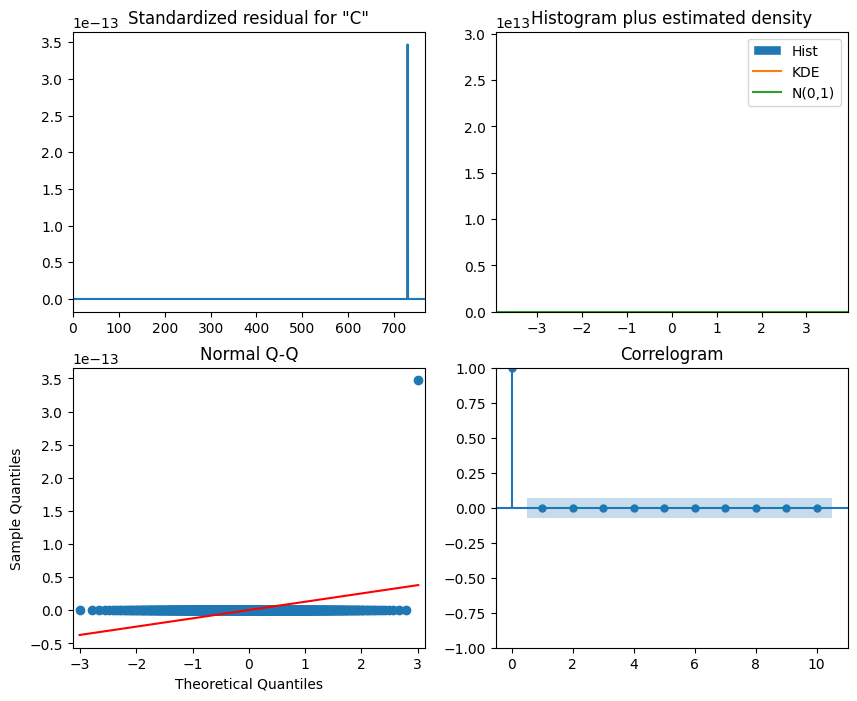

In [15]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

In [16]:
residuals = best_model_fit.resid

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

pvalue['lb_pvalue']

1     0.996126
2     0.999977
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
Name: lb_pvalue, dtype: float64

In [17]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [24]:
len(target)-14

924

In [29]:
target_train = target[:248]
target_test = target[248:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
248,0.033060,0.033039,0.033039
249,0.033103,0.033060,0.033060
250,0.033051,0.033103,0.033103
251,0.033228,0.033051,0.033051
252,0.033299,0.033228,0.033228
253,0.033860,0.033299,0.033299
254,0.033849,0.033860,0.033860
255,0.033371,0.033849,0.033849
256,0.033335,0.033371,0.033371
257,0.033303,0.033335,0.033335


In [30]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.37143623736631043 0.3714362373816263


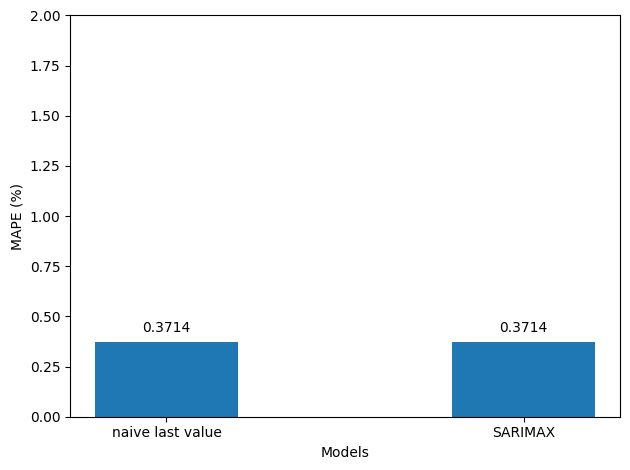

In [33]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,4)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=400)